In [ ]:
# this is copied from (20.10)flavoringr_tfidf

In [22]:
pip install scikit-learn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 281.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 382.9 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 352.8 kB/s eta 0:00:00a 0:00:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from ast import literal_eval
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time
import os

In [5]:
os.getcwd()

'/Users/qingzhang/Desktop/data&code/experiments_on_the_flavour_aspects/origin_prediction/tfidf'

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.metrics import accuracy_score

In [4]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [9]:
xcf_data=pd.read_pickle('~/Desktop/data&code/experiments_on_the_flavour_aspects/datasets/xcf_flavordb_data.pkl')
ars_data=pd.read_pickle('~/Desktop/data&code/experiments_on_the_flavour_aspects/datasets/ars_flavordb_data.pkl')
kb_data=pd.read_pickle('~/Desktop/data&code/experiments_on_the_flavour_aspects/datasets/kb_flavordb_data.pkl')

In [10]:
print(xcf_data.shape)
print(ars_data.shape)
print(kb_data.shape)

(11821, 2)
(10623, 2)
(9047, 2)


In [11]:
xcf_data=xcf_data.explode('flavordb_ingrs').reset_index(drop=True)
ars_data=ars_data.explode('flavordb_ingrs').reset_index(drop=True)
kb_data=kb_data.explode('flavordb_ingrs').reset_index(drop=True)

In [12]:
xcf_data=pd.DataFrame(xcf_data.groupby('recipe_id')['flavordb_ingrs'].apply(set)).reset_index()
ars_data=pd.DataFrame(ars_data.groupby('recipe_id')['flavordb_ingrs'].apply(set)).reset_index()
kb_data=pd.DataFrame(kb_data.groupby('recipe_id')['flavordb_ingrs'].apply(set)).reset_index()

In [13]:
print(xcf_data.shape)
print(ars_data.shape)
print(kb_data.shape)

(11821, 2)
(10623, 2)
(9047, 2)


In [14]:
xcf_data['flavordb_ingrs']=xcf_data['flavordb_ingrs'].apply(lambda x:sorted(x))
ars_data['flavordb_ingrs']=ars_data['flavordb_ingrs'].apply(lambda x:sorted(x))
kb_data['flavordb_ingrs']=kb_data['flavordb_ingrs'].apply(lambda x:sorted(x))

In [15]:
xcf_data['origin']=0
ars_data['origin']=1
kb_data['origin']=2

In [16]:
allflavor_ingr=pd.concat([xcf_data,ars_data,kb_data],axis=0).reset_index(drop=True)
allflavor_ingr.shape

(31491, 3)

In [17]:
[','.join(map(str,ingr)) for ingr in allflavor_ingr['flavordb_ingrs']]

['capsicum,garlic,lettuce',
 'cake,chocolate,cream,gelatin,sugar,water,yogurt',
 'cabbage,oats,pepper,rice,salt',
 'avocado,sesame,soybean_sauce',
 'butter,egg,flour,milk,salt,water',
 'broccoli,cooking_oil,pork,salt',
 'butter,condensed_milk,egg,flour,milk_powder,salt,sugar,water',
 'cooking_oil,enokitake,ginger,pork,salt,soybean_sauce',
 'cream,durian,egg,lemon,milk,sugar',
 'cabbage,capsicum,garlic,salt,sesame,soybean_sauce,tomato',
 'cream,mango,sugar,yogurt',
 'cabbage,cooking_oil,garlic,ginger,salt,shiitake,soybean_sauce,sugar',
 'cooking_oil,durian,egg,flour,lemon,milk,sugar',
 'durian,water',
 'butter,cranberry,egg,flour,sugar',
 'ashgourd,coriander,lamb,pepper,salt,welsh_onion',
 'cooking_oil,garlic,ginger,pepper,salt,shrimp,towel_gourd,water,welsh_onion',
 'cooking_oil,eggplant,garlic,ginger,salt,soybean_sauce,sugar,vinegar,water,welsh_onion',
 'ginger,pepper,pork,soybean_sauce,welsh_onion',
 'beans,beef,capsicum,enokitake,garlic,soybean_sauce,water,welsh_onion',
 'cooking_oi

In [18]:
allflavor_ingr['flavordb_ingrs']=[','.join(map(str,ingr)) for ingr in allflavor_ingr['flavordb_ingrs']]

In [15]:
# split train and test set

In [ ]:
train_df,test_df,train_y,test_y=train_test_split(allflavor_ingr['flavordb_ingrs'],allflavor_ingr['origin'],test_size=0.3,random_state=42)

In [ ]:
print('Num. of samples in training set:',train_df.shape)
print('Num. of samples in test set:',test_df.shape)

In [18]:
tfidf_transformer=TfidfVectorizer()

In [19]:
train_X=tfidf_transformer.fit_transform(train_df)
test_X=tfidf_transformer.transform(test_df)

In [20]:
print(train_X.shape)
print(test_X.shape)

(22043, 460)
(9448, 460)


In [21]:
train_X=train_X.toarray()
test_X=test_X.toarray()

In [22]:
# NB
def NB_pipeline(train_X,test_X,train_y,test_y):
    nb = MultinomialNB()
    cv=ShuffleSplit(n_splits=10,test_size=0.3,random_state=9527)
    nb_cv_results=cross_val_score(nb,train_X,train_y,cv=cv)
    nb.fit(train_X,train_y)
    y_pred=nb.predict(test_X)
    print('Mean Accuracy: %0.2f (+/- %0.2f)' % (nb_cv_results.mean(), nb_cv_results.std() * 2))
    print('Accuracy on test set: %0.2f' % accuracy_score(y_pred,test_y))
    return y_pred

In [23]:
# logistic regression
def log_pipeline(train_X,test_X,train_y,test_y):
    clf=LogisticRegression(multi_class='multinomial',random_state=9527)
    param_distribs={'C':[0.1,1,10,100,1000],
                    'solver':['lbfgs','saga']}
    log_search=RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    log_search.fit(train_X,train_y)
    print('Best parameters:',log_search.best_params_)
    print('Best estimatro:',log_search.best_estimator_)
    print('Best score:',log_search.best_score_)
    log=log_search.best_estimator_
    log.fit(train_X,train_y)
    y_pred=log.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [24]:
# random forest
def rf_pipeline(train_X,test_X,train_y,test_y):
    clf=RandomForestClassifier(random_state=42)
    param_distribs={'n_estimators':[int(x) for x in np.linspace(start = 300, stop = 500, num = 10)],
                    'max_features':['auto','sqrt','log2'],
                    'max_depth':[5,6,7,8,9,10],
                    'criterion':['gini','entropy']}
    random_search = RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    random_search.fit(train_X,train_y)
    print('Best parameters:',random_search.best_params_)
    print('Best estimatro:',random_search.best_estimator_)
    print('Best score:',random_search.best_score_)
    rf=random_search.best_estimator_
    rf.fit(train_X,train_y)
    y_pred=rf.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [25]:
nby_pred=NB_pipeline(train_X,test_X,train_y,test_y)

Mean Accuracy: 0.77 (+/- 0.01)
Accuracy on test set: 0.77


In [26]:
start_time=time.time()
logy_pred=log_pipeline(train_X,test_X,train_y,test_y)
print(time.time()-start_time)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters: {'solver': 'saga', 'C': 1000}
Best estimatro: LogisticRegression(C=1000, multi_class='multinomial', random_state=9527,
                   solver='saga')
Best score: 0.8125027219114178
accuracy score:  0.8107535986452159
173.95978164672852


In [27]:
rfy_pred=rf_pipeline(train_X,test_X,train_y,test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 322, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
Best estimatro: RandomForestClassifier(max_depth=10, n_estimators=322, random_state=42)
Best score: 0.7352898748188308
accuracy score:  0.732324301439458


In [ ]:
# learning curve

In [29]:
# Learning curve
def plot_cv_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

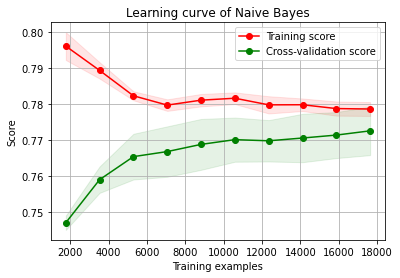

In [38]:
estimator=MultinomialNB()
plot_cv_learning_curve(estimator, 'Learning curve of Naive Bayes', train_X, train_y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/ingr_tfidf_nb_lc.pdf',dpi=300, bbox_inches='tight')
plt.savefig('fig/png/ingr_tfidf_nb_lc.png',dpi=300, bbox_inches='tight')

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

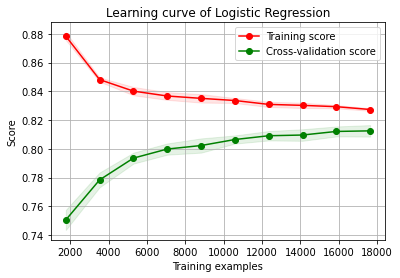

In [39]:
estimator=LogisticRegression(C=1000, multi_class='multinomial', random_state=9527,
                   solver='saga')
plot_cv_learning_curve(estimator, 'Learning curve of Logistic Regression', train_X, train_y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/ingr_tfidf_log_lc.pdf',dpi=300, bbox_inches='tight')
plt.savefig('fig/png/ingr_tfidf_log_lc.png',dpi=300, bbox_inches='tight')

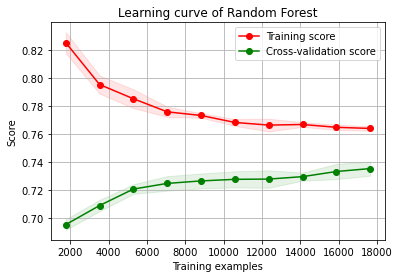

In [40]:
estimator=RandomForestClassifier(max_depth=10, n_estimators=322, random_state=42)
plot_cv_learning_curve(estimator, 'Learning curve of Random Forest', train_X, train_y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10))
plt.savefig('fig/pdf/ingr_tfidf_rf_lc.pdf',dpi=300, bbox_inches='tight')
plt.savefig('fig/png/ingr_tfidf_rf_lc.png',dpi=300, bbox_inches='tight')

In [ ]:
# confusion matrix

In [42]:
def plot_confusion_matrix(cm,classes,title,normalize=False,cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=14)
    plt.yticks(tick_marks, classes,fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=14)

    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label',fontsize=14)
    plt.tight_layout()

In [46]:
log_cm=confusion_matrix(logy_pred,test_y)
np.set_printoptions(precision=2)

In [47]:
log_cm

array([[3196,  362,  265],
       [ 224, 2435,  418],
       [ 136,  383, 2029]])

Normalized confusion matrix
[[0.84 0.09 0.07]
 [0.07 0.79 0.14]
 [0.05 0.15 0.8 ]]


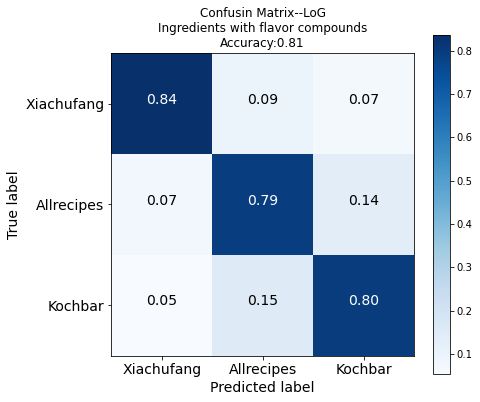

In [50]:
plt.figure(figsize=(7,6))
plot_confusion_matrix(log_cm,normalize=True,classes=['Xiachufang','Allrecipes','Kochbar'],
                      title='Confusin Matrix--LoG\nIngredients with flavor compounds\nAccuracy:{0:.2f}'.format(accuracy_score(test_y,logy_pred)))
plt.savefig('fig/pdf/flavoringr_LOG_cm.pdf',dpi=300,bbox_inches='tight')
plt.savefig('fig/png/flavoringr_LOG_cm.png',dpi=300,bbox_inches='tight')